In [23]:
#Importing important libraries for data analysis
from statistics import mean
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import matplotlib.pyplot as plt
from math import sqrt
from xgboost import XGBRegressor
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
import os
from sklearn.preprocessing import LabelEncoder
import pickle


In [24]:
#Creation of new dataframes to store refined values of datasets
new_df = pd.DataFrame()
test_new_df = pd.DataFrame()

In [25]:
#Creation of pandas dataframes for train.csv, oil.csv and test.csv
#sorted by store numbers & family
train_df = pd.read_csv("train.csv").sort_values(["store_nbr", "family"])
test_df = pd.read_csv("test.csv").sort_values(["store_nbr", "family"])
oil_df  = pd.read_csv("oil.csv")

In [26]:
#calculation of mean for oil price
dcoilwtico_mean = mean(oil_df["dcoilwtico"].dropna())

#filling null values of oil prices by mean
oil_df['dcoilwtico'] = oil_df["dcoilwtico"].fillna(dcoilwtico_mean)


#joining oil and train csv to get oil prices
merged_df = train_df.merge(oil_df, on = 'date', how = 'left')
merged_df['dcoilwtico'] = merged_df["dcoilwtico"].fillna(dcoilwtico_mean)

#cleaning family names from column
merged_df['family'] = merged_df['family'].str.replace("/", " ")
merged_df['family'] = merged_df['family'].str.replace(",", " ")


In [27]:
#An empty dictionary created for storing lists as values
unique = {}

#defines unique store numbers in the train data
unique['strnbr_unique'] = merged_df["store_nbr"].dropna().unique()

#defines unique families of products in the train data
unique['family_unique'] = merged_df["family"].dropna().unique()

rmsle_list = []

In [28]:
#Function showing calculation of Root Mean Square Logarithmic Errror
def rmsle(y_true, y_pred):
    #Ensuring no negative values go through
    y_pred[y_pred<0]=0.0
    
    #Taking square root of mean squared log error 
    metric = np.sqrt(mean_squared_log_error(y_true, y_pred))
    
    #rounding up the values till 3 decimal places
    return round(metric, 3)

In [29]:
#Creating valid dataset for each unique family
def dataset_creation(fam, df):
    temp_df = df[(df["family"] == fam)]
    
    #making a shift of 1 for previous day sales
    temp_df["prev_sales"] = temp_df["sales"].shift(1)
    
    #filtering out all the 0 values of sales
    temp_df['prev_sales'] = temp_df['prev_sales'].fillna(0.0)
    
    #sorting data by store number and dates, dropping date, id and sales
    temp_df = temp_df.sort_values(['store_nbr','date']).drop(['date', 'id', "family"], axis = 1)

    return temp_df

In [30]:
#Function to use the model
def model_reuse(model_name): 
    model = XGBRegressor()
    model.load_model(model_name)
    return model

In [31]:
def train_model(fam, train_df):
    new_df_train = dataset_creation(fam, train_df)
    
    #creating train and test split sets, taking 80 percent of data for train
    train = new_df_train[:int(len(new_df_train) * 0.8)]
    test = new_df_train[int(len(new_df_train) * 0.8):]
    
    #replacing null values of train, converting to numpy arrays for in, out 
    train = train.fillna(0.0).to_numpy()
    test = test.to_numpy()
    
    #creating train and test for input and output sets
    train_in, train_out = train[:, :-1], train[:, -1]
    test_in, test_out = test[:, :-1], test[:,-1]

    #####################################################################
    
    #providing the parameters for XGbosst model
    params = {'objective': 'reg:squarederror'}
    
    #setting the estimators to 1500
    model = XGBRegressor(params=params,n_estimators=1500)
    
    #fitting the model
    model_fitting = model.fit(train_in, train_out)
    
    #predicting on test set
    yhat = (model_fitting.predict(test_in))
    
    #original values for rmsle
    y = test_out

    #using function to calculate rmsle values
    rmsle_value = rmsle(y, yhat)
    
    
    #EDA for plots of prediction
    plt.figure(figsize=(15,5))
    plt.plot(y[:100], label='Original sales')
    plt.plot(yhat[:100], label='Predicted sales')
    plt.legend()
    plt.show()

    #saving the models
    model_fitting.save_model('./modelTrain_' + str(fam) + '.bin')
    return rmsle_value

[23:49:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




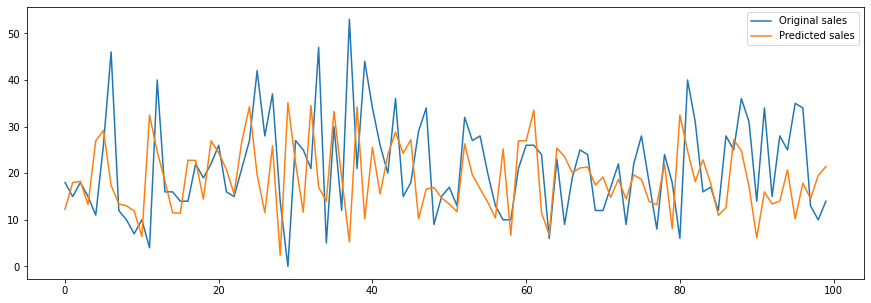

family: AUTOMOTIVE 0.92
[23:49:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




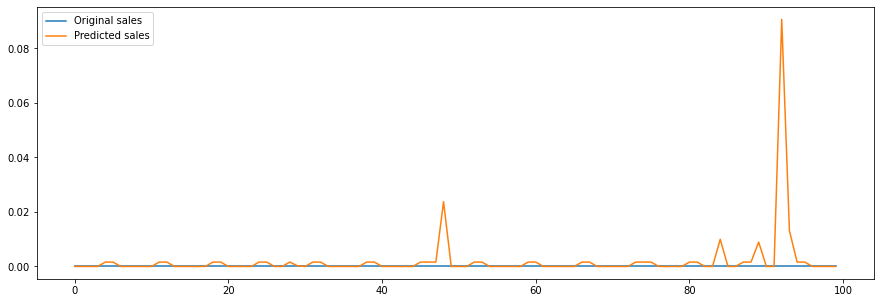

family: BABY CARE 0.125
[23:50:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




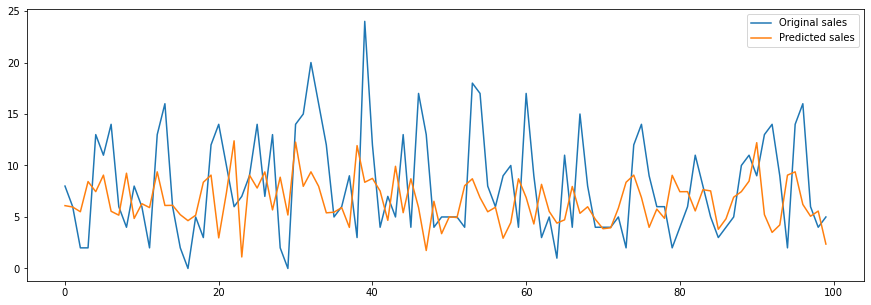

family: BEAUTY 1.186
[23:50:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




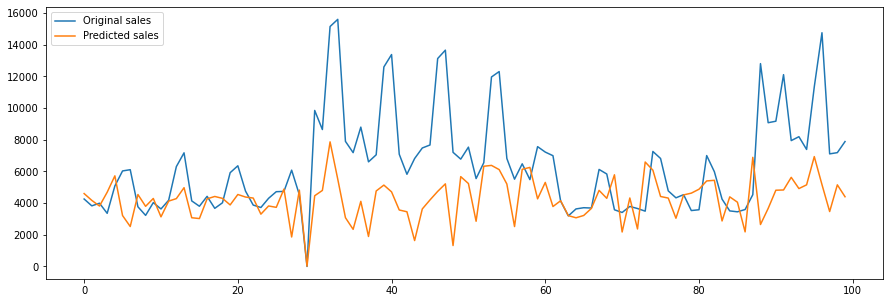

family: BEVERAGES 2.891
[23:51:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




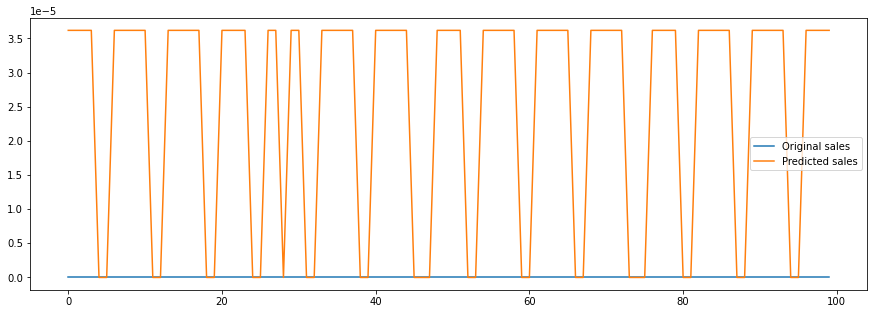

family: BOOKS 0.225
[23:51:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




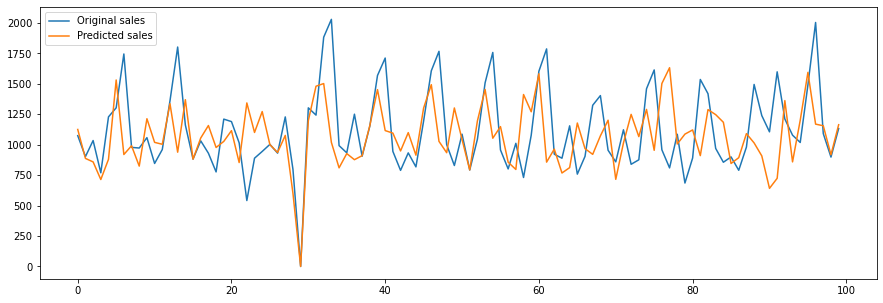

family: BREAD BAKERY 2.187
[23:52:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




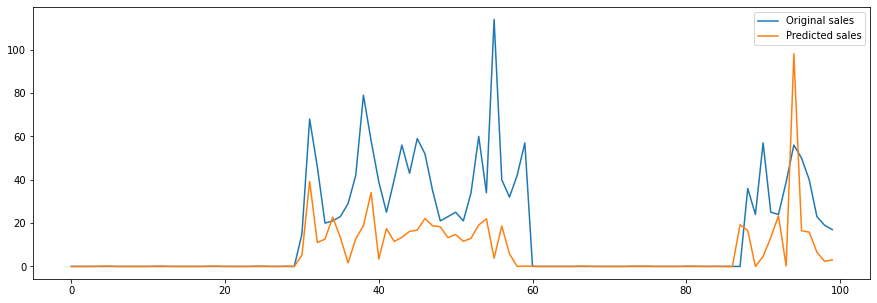

family: CELEBRATION 0.903
[23:52:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




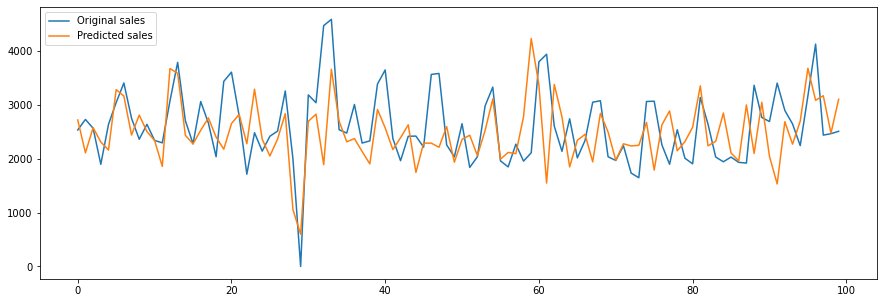

family: CLEANING 2.283
[23:53:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




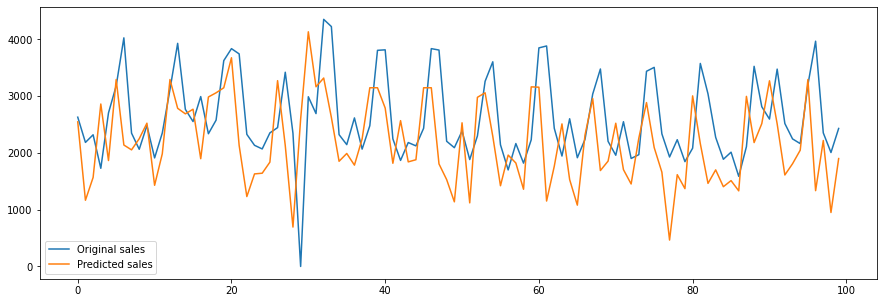

family: DAIRY 2.234
[23:53:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




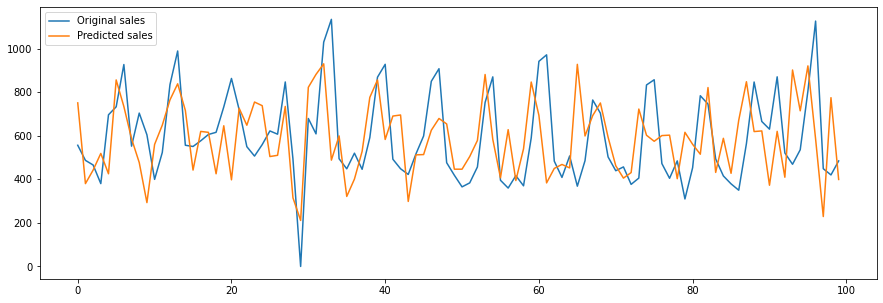

family: DELI 1.99
[23:54:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




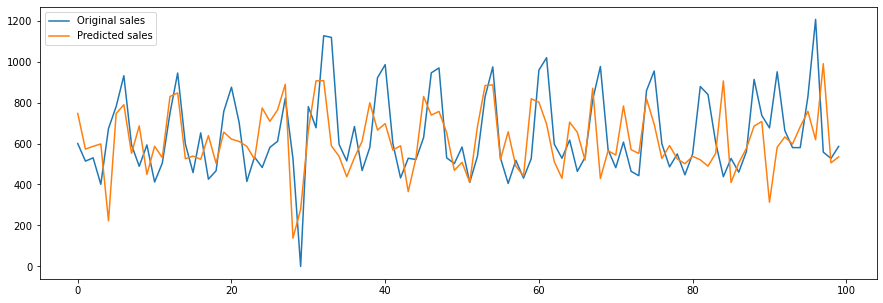

family: EGGS 1.814
[23:54:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




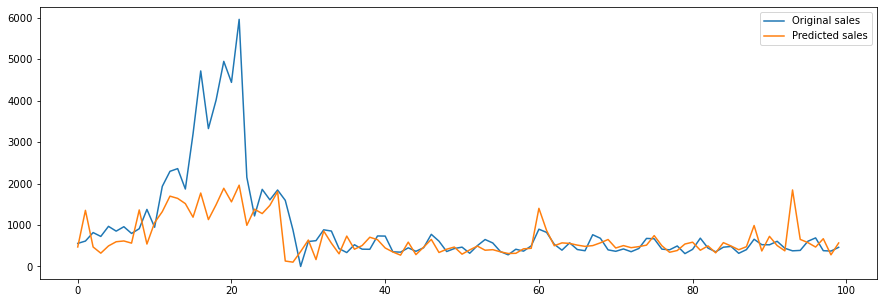

family: FROZEN FOODS 1.735
[23:55:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




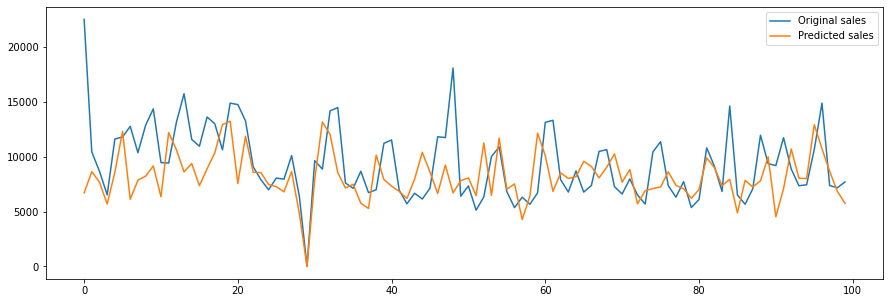

family: GROCERY I 2.85
[23:56:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




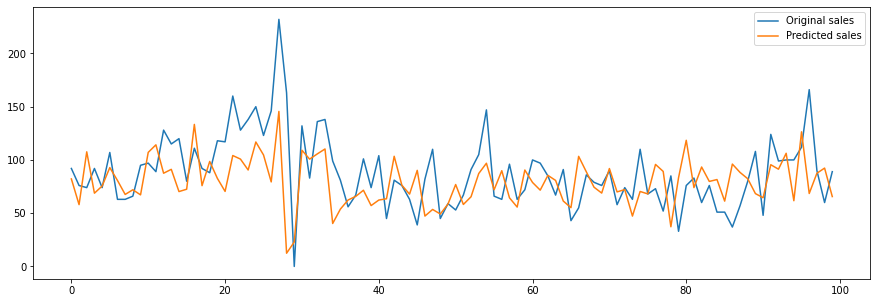

family: GROCERY II 1.259
[23:56:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




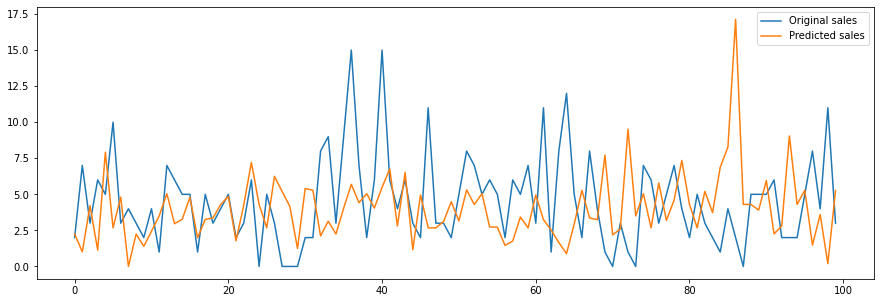

family: HARDWARE 1.176
[23:57:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




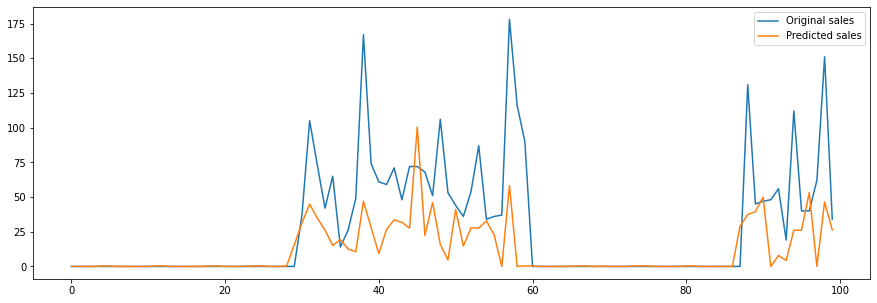

family: HOME AND KITCHEN I 1.073
[23:57:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




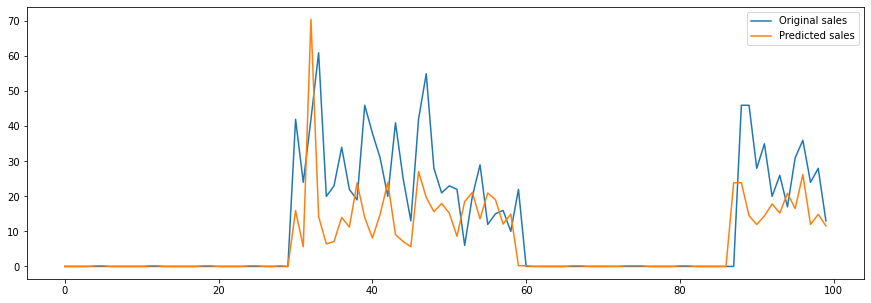

family: HOME AND KITCHEN II 0.837
[23:57:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




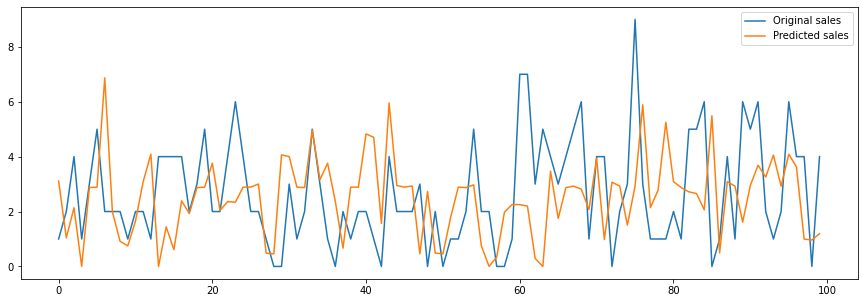

family: HOME APPLIANCES 0.704
[23:58:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




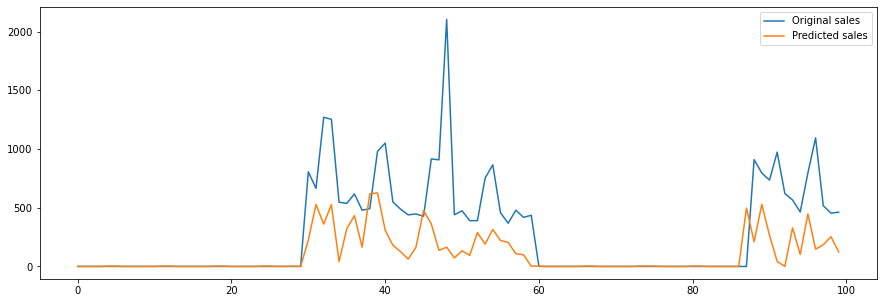

family: HOME CARE 1.449
[23:58:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




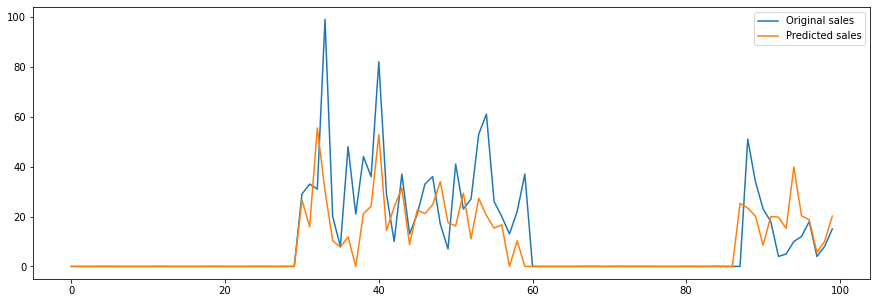

family: LADIESWEAR 0.762
[23:59:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




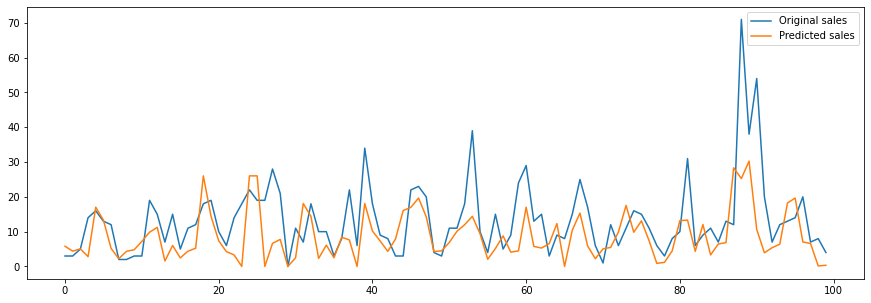

family: LAWN AND GARDEN 1.343
[23:59:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




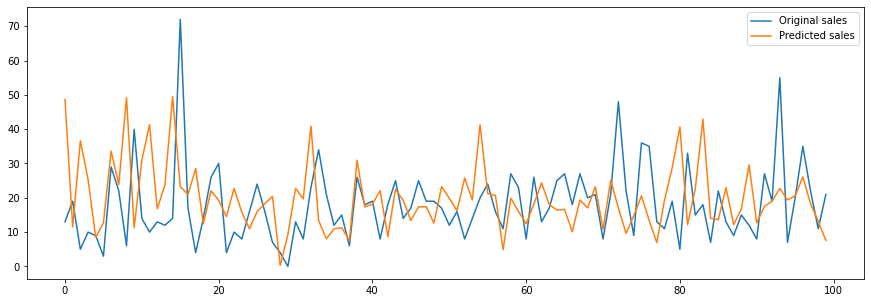

family: LINGERIE 1.182
[23:59:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




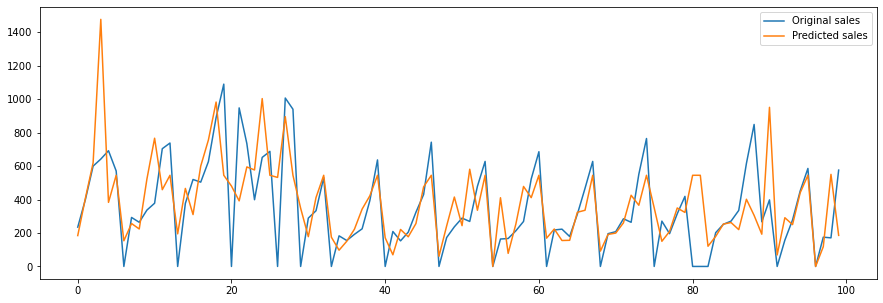

family: LIQUOR WINE BEER 2.761
[00:00:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




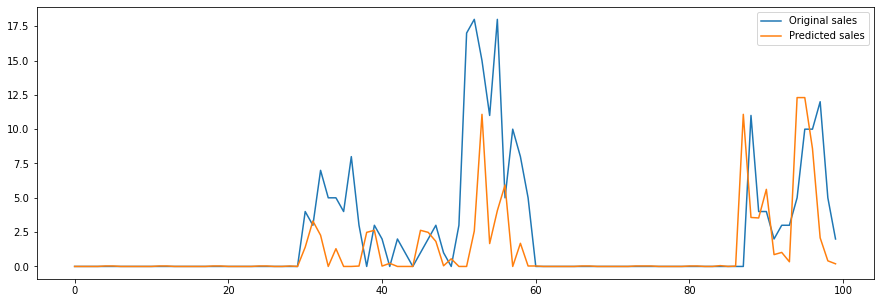

family: MAGAZINES 0.979
[00:00:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




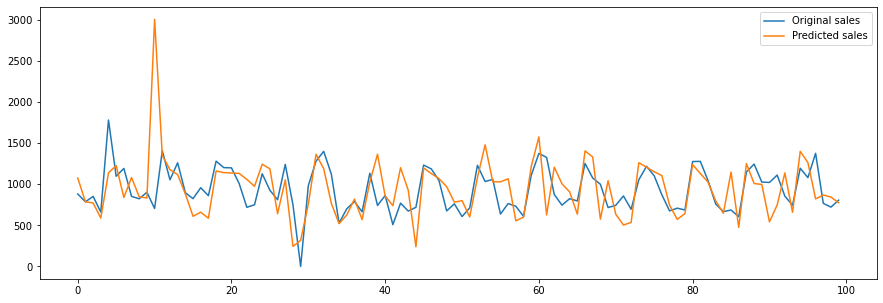

family: MEATS 1.969
[00:01:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




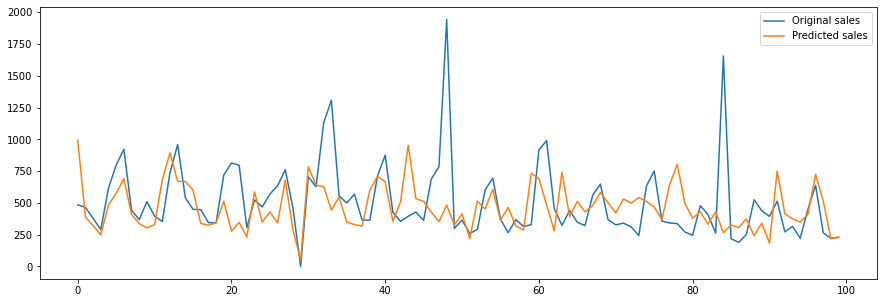

family: PERSONAL CARE 1.973
[00:02:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




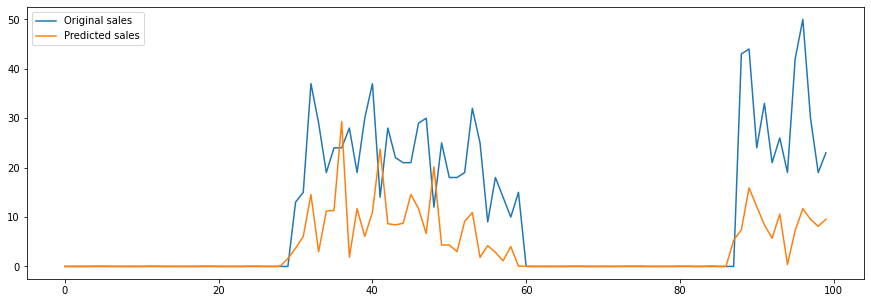

family: PET SUPPLIES 1.016
[00:02:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




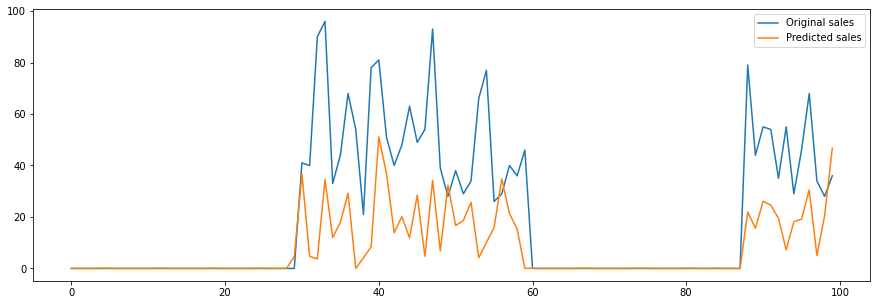

family: PLAYERS AND ELECTRONICS 0.946
[00:03:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




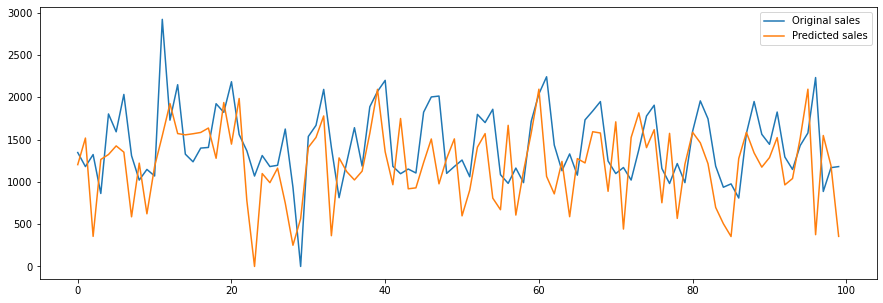

family: POULTRY 1.949
[00:04:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




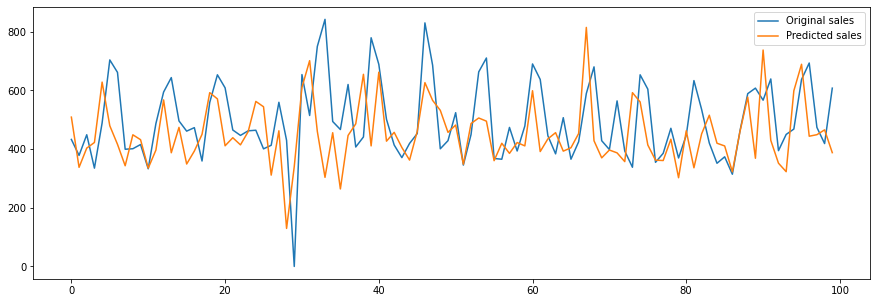

family: PREPARED FOODS 1.759
[00:04:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




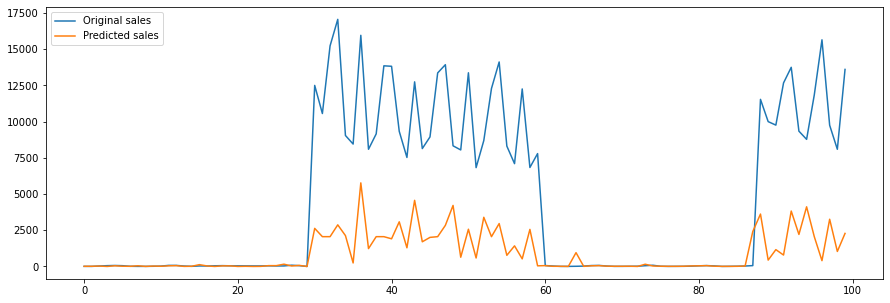

family: PRODUCE 1.875
[00:05:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




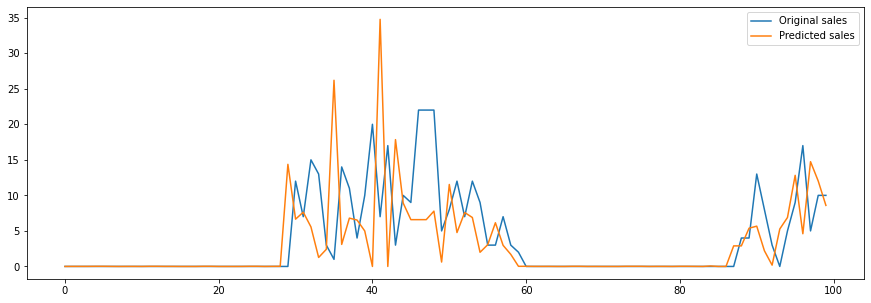

family: SCHOOL AND OFFICE SUPPLIES 0.77
[00:06:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




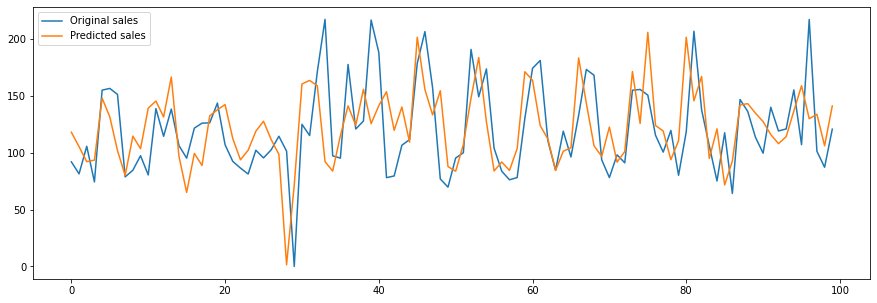

family: SEAFOOD 0.906


In [32]:
#deriving the rmsle and models for each family
for fam in unique['family_unique'] :
    rmsle_value = train_model(fam, merged_df)
    #storing rmsle values in a list
    rmsle_list.append(rmsle_value)
    print("family:", fam, rmsle_value)

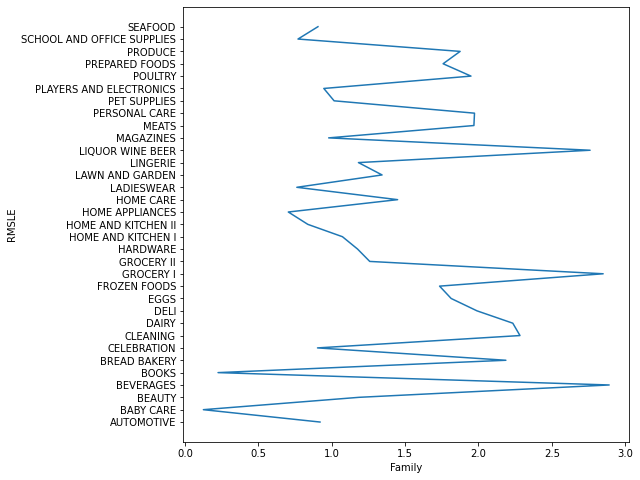

In [33]:
#plotting the rmsle values for XGBoost
plt.figure(figsize=(8,8))
plt.xlabel('Family', fontsize=10)
plt.ylabel('RMSLE', fontsize=10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.plot(rmsle_list, unique['family_unique'])
plt.show()

In [34]:
#joining the oil and test data
join_test_df = test_df.merge(oil_df, on = 'date', how = 'left')

#replacing the null values with mean
join_test_df['dcoilwtico'] = join_test_df["dcoilwtico"].fillna(dcoilwtico_mean)

#Cleaning the family names of test csv
join_test_df['family'] = join_test_df['family'].str.replace("/", " ")
join_test_df['family'] = join_test_df['family'].str.replace(",", " ")


In [35]:
#creating lists of unique values in test csv
unique['test_strnbr_unique'] = join_test_df["store_nbr"].dropna().unique()
unique['test_family_unique'] = join_test_df["family"].dropna().unique()
unique['test_date_unique'] = join_test_df["date"].dropna().unique()


In [36]:
#creating the forecast for test dataset
test_final_df = pd.DataFrame()
for i in unique['test_family_unique']:
    #last date's data from train dataset is chosen
    temp_join_df = merged_df[(merged_df["family"] == i) & (merged_df['date'] == '2017-08-15')]
    temp_join_df = temp_join_df.sort_values(['store_nbr', 'date'])
    
    #data of train saved in lists
    list_sales = temp_join_df['sales'].to_list()
    list_family = temp_join_df['family'].to_list()
    
    #reusing the models
    model_fit = model_reuse('./modelTrain_' + str(i) + '.bin')
    
    for j in unique['test_date_unique']:
        temp_df = join_test_df[(join_test_df["family"] == i) & (join_test_df['date'] == j)]
        #adding sales column to dataframe
        temp_df['sales'] = list_sales
        
        #dropping the columns for prediction
        temp_df = temp_df.drop(['id', 'family', 'date'], axis = 1)
        test_inp = temp_df.to_numpy()
    
        #adding forecast column for predicted values on test data
        temp_df['forecast'] = model_fit.predict(test_inp)
        
        #removing negative values from datag=frame
        temp_df['forecast'] = temp_df['forecast'].apply(lambda x : x if x > 0 else 0)
        temp_df['family'] = list_family
        test_final_df = test_final_df.append(temp_df, ignore_index = True)
        
        #updating the sales values
        list_sales = temp_df['forecast']


In [38]:
# test_final_df is the final dataset, saved as csv file
test_final_df.to_csv("ForeCasted_XGB") 
# test_final_df

,store_nbr,onpromotion,dcoilwtico,sales,forecast,family
0,1,0,46.80,4.0,0.000000,AUTOMOTIVE
1,2,0,46.80,2.0,1.548369,AUTOMOTIVE
2,3,0,46.80,12.0,6.460938,AUTOMOTIVE
3,4,0,46.80,7.0,5.511446,AUTOMOTIVE
4,5,0,46.80,9.0,6.410841,AUTOMOTIVE
...,...,...,...,...,...,...
28507,50,1,47.26,NaN,6.032209,SEAFOOD
28508,51,1,47.26,NaN,6.032209,SEAFOOD
28509,52,1,47.26,NaN,6.032209,SEAFOOD
28510,53,0,47.26,NaN,5.983581,SEAFOOD
